### 👨‍🏭 Albertus Septian Angkuw

#### Pembuatan Call Graph

In [26]:
%pip install pycg

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [27]:
# currentPath = input("")
currentPath = "/home/asa/Documents/Skripsi/TA-1119002/rancangan-dekomposisi/odoo16"
print('Current Path set:' ,currentPath)

Current Path set: /home/asa/Documents/Skripsi/TA-1119002/rancangan-dekomposisi/odoo16


In [28]:
import os
def walkTroughFolder(folderSC,filterExt='.py'):
    listFile = []
    for file in os.listdir(f'{currentPath}/{folderSC}'):
        if os.path.isdir(f'{currentPath}/{folderSC}/{file}'):
            listFile += walkTroughFolder(f'{folderSC}/{file}')
        elif file.endswith(filterExt):
            #print(os.path.join(f'/{folderSC}', file))
            listFile.append(os.path.join(f'/{folderSC}', file))
    return listFile

In [29]:
import time
def scanPyCG(currentPath,package):
    timestamp = int(time.time())
    targetFile = f'py_files=$(find {currentPath}/{package} -type f -name "*.py")'
    execute = f'pycg --package {package} $py_files -o {currentPath}/{package}-{timestamp}.json '
    os.system(f'{targetFile} && {execute}')
    return f'{currentPath}/{package}-{timestamp}.json'

In [30]:
print(f'Total py Files "Odoo": {len(walkTroughFolder("odoo"))} Files "Addons": {len(walkTroughFolder("addons"))} ')

Total py Files "Odoo": 412 Files "Addons": 4853 


In [31]:
# addonsJSON = scanPyCG(currentPath,f'{folderSC}/addons')
# odooJSON = scanPyCG(currentPath,f'{folderSC}/odoo')

In [32]:
addonsJSON = f'{currentPath}/odooOnlyAddonsNoPackage.json'
odooJSON = f'{currentPath}/odooCoreNoPackage.json'

#### Pembacaan Hasil Call Graph JSON

In [33]:
import json
def loadJSON(path):
   return json.load(open(path))

In [34]:
cgAddonsSource =loadJSON(addonsJSON)
cgOdooSource =loadJSON(odooJSON)
print(list(cgAddonsSource.values())[:5])
print(list(cgOdooSource.values())[:5])

[[], [], ['odoo.api.depends'], ['odoo.fields.Date.today', 'odoo.models.Model.product_id.with_company', 'odoo.models.Model.browse', '<builtin>.super'], []]
[[], [], [], ['odoo.fields.Char'], []]


In [35]:
print(len(cgOdooSource))
print(len(cgAddonsSource))

5586
24931


In [36]:
def getListRootPackage(path):
    listRootPackage = []
    for file in os.listdir(f'{path}'):
        if os.path.isdir(f'{path}/{file}'):
            listRootPackage.append(file)
        elif file.endswith('.py'):
            listRootPackage.append('.'.join(file.split(".")[:-1]))
    return listRootPackage

In [37]:
def addPrefixFolder(cg,root,listPackage):
    def checkParent(key):
        parentkey = key.split('.')[0]
        if parentkey in listPackage:
            key = f'{root}.{key}'
        return key
    newCG = {}
    for key, relation in cg.items():
        key = checkParent(key)
        if key not in newCG:
            newCG[key] = []
        for i in relation:
            newRelKey = checkParent(i)
            newCG[key].append(newRelKey)
    return newCG

In [38]:
listPackageOdoo = getListRootPackage(f'{currentPath}/odoo')
listPackageAddons = getListRootPackage(f'{currentPath}/addons')

In [39]:
cgOdoo = addPrefixFolder(cgOdooSource,"odoo",listPackageOdoo)
cgAddons = addPrefixFolder(cgAddonsSource,"addons",listPackageAddons)

In [40]:
cgSource = {}
for key, rel in cgOdoo.items():
    if key not in cgSource:
        cgSource[key] = []
    for tmp in rel:
        if tmp not in cgSource:
            cgSource[tmp] = []
    cgSource[key] = cgSource[key] + rel

for key, rel in cgAddons.items():
    if key not in cgSource:
        cgSource[key] = []
    for tmp in rel:
        if tmp not in cgSource:
            cgSource[tmp] = []
    cgSource[key] = cgSource[key] + rel

In [41]:
len(cgSource)

29821

#### Visualisasi Call Graph

In [42]:
%pip install pygraphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [43]:
import pygraphviz as pgv
def cobaDot():
    d = {"1": {"2": 7 }, "2": {"1": 1, "3": 1, "5" : 1}}
    A = pgv.AGraph(d,strict=False, directed=True)
    A.layout(prog="dot")
    A.draw(f'{currentPath}/contoh-CG.svg') 
    print(A)
#cobaDot()

In [46]:
def buatGraphviz(graph, _strict=False, _directed=True,_prog="fdp",filename="GV"):
    A = pgv.AGraph(graph,strict=_strict, directed=_directed)
    A.layout(prog=_prog)
    A.draw(f'{currentPath}/{filename}.svg') 
    print(f'Image saved at: {currentPath}/{filename}.svg')

#### Call Graph Raw

In [47]:
callGraphRaw = {}
for key, value in cgSource.items():
    callGraphRaw[key] = {}
    for v in value:
        callGraphRaw[key][v] = 1

In [48]:
# buatGraphviz(graph=callGraphRaw,filename=f'{folderSC}-RAW-CG')

#### Filter Call diluar Project

In [49]:
callGraphFiltered = {}
listRootFolder = [ 'odoo', 'addons']
edgeGraph = []
outsideCall = set()
for key, value in cgSource.items():
    rootSource = key.split('.')[0]
    if rootSource not in listRootFolder:
        outsideCall.add(rootSource)
        continue
    childFilter = {}
    for v in value:
        childSource = v.split('.')[0]
        if childSource not in listRootFolder:
            outsideCall.add(childSource)
            continue
        childFilter[v] = 1
    if len(childFilter) == 0:
        edgeGraph.append(key)
        continue
    for c in childFilter:
        if c not in callGraphFiltered:
            callGraphFiltered[c] = {}
    callGraphFiltered[key] = childFilter
    
print(f'Total Top Node: {len(callGraphFiltered)} ')
print(f'Total Edge: {len(edgeGraph)} <{edgeGraph[:3]}>')
print(f'Total OutsideEdge: {len(outsideCall)} <{list(outsideCall)[:3]}>')

Total Top Node: 17282 
Total Edge: 15457 <['odoo.addons.test_inherits_depends.__manifest__', 'odoo.addons.test_inherits_depends.models', 'odoo.fields.Char']>
Total OutsideEdge: 157 <['abc', 'cProfile', 'signal']>


In [50]:
# buatGraphviz(callGraphFiltered,filename=f'{folderSC}-CG')

#### Extrasi Data

In [1]:
import os
import importlib.util
import inspect

In [2]:
def symlink_rel(src, dst):
    rel_path_src = os.path.relpath(src, os.path.dirname(dst))
    os.symlink(rel_path_src, dst)

In [3]:
# Checks if file is a broken link. 0: broken link; 1: valid link; 2: not a link
def isvalidlink(path):
    if not os.path.islink(path):
        return 2
    try:
        os.stat(path)
    except os.error:
        return 0
    return 1

In [4]:
def merge_symlink(target, source):
    counter = 0
    for file in os.listdir(source):
        if os.path.isdir(f'{source}/{file}') :
            if os.path.isdir(f'{target}/{file}'):
                print("Existing Folder in target folder " , file)
                continue
            if isvalidlink(f'{target}/{file}') == 1:
                os.unlink( f'{target}/{file}')
                # print("Removed Old Link in target folder " , file)
            symlink_rel(f'{source}/{file}', f'{target}/{file}')
            if isvalidlink(f'{target}/{file}') == 0:
                print("Please Remove broken symlink: {}".format(file))
                return 
            counter+=1
            # print(f'Added Symslink: {source}/{file} -> {target}/{file}')
    print("Success Added {} symlink".format(counter))    

In [5]:
def unmerge_symlink(target):
    # Delete All Links
    counter = 0
    for file in os.listdir(target):
        link = os.path.join(target,file)
        if isvalidlink(link) == 1:
            os.unlink( f'{target}/{file}')
            counter+=1
            # print("Clean Up  symlink: {}".format(file))
    print("Success Clean Up {} symlink".format(counter))    

In [6]:
def pathToModule(files,removeFile=True):
    coreModule = []
    for x in files:
        if x.count('.') > 1:
            print("Skipped, Path Contain '.' : " , x)
            continue
        tmpArr = x[:-3].split("/")[2:]
        if removeFile:
            tmpArr = tmpArr[:-1]
        tmp = '.'.join(tmpArr)
        if tmp not in coreModule:
            coreModule.append(tmp)
    return coreModule

In [57]:
listModule = [ f'{"odoo."}{s}' for s in pathToModule(walkTroughFolder('odoo')) ]
listModule += [ f'{"addons."}{s}' for s in pathToModule(walkTroughFolder('addons'))]

Skipped, Path Contain '.' :  /addons/web/static/lib/py.js/doc/conf.py
Skipped, Path Contain '.' :  /addons/l10n_sg/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_sg/migrations/2.1/post-migrate_update_tax.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr04/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr04/migrations/3.1/post-migrate_update_taxes.py
Skipped, Path Contain '.' :  /addons/l10n_pl/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_no/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_no/migrations/2.1/post-migrate_update_taxes.py
Skipped, Path Contain '.' :  /addons/l10n_it/migrations/15.0.0.3/post-migrate.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr03/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr03/migrations/3.1/

In [15]:
def scanModule(modulePath):
    # modulePath = "addons.account.models"
    runcommand = importlib.import_module(modulePath)
    listClass = {}
    for name, obj in inspect.getmembers(runcommand):
        if inspect.ismodule(obj):
            # print("Module:" ,  name)
            member = inspect.getmembers(obj)
            tmpClass = {}
            for item in member:
                if inspect.isclass(item[1]):
                    print(item[1])
                    if hasattr(item[1], '__class__') and str(item[1].__class__) != "<class 'odoo.models.MetaModel'>":
                        # print(f'Class "{item[0]}" Skipped because not MetaModel')
                        continue
                    if hasattr(item[1], '_name'):
                        tmpClass[item[0]] = { 'name' : item[1]._name}
                    if hasattr(item[1], '_inherit'):
                        tmpClass[item[0]]['inherit'] = item[1]._inherit                       
                    if hasattr(item[1], '_inherits'):
                        tmpClass[item[0]]['inherits'] = item[1]._inherits
                    classMembers = inspect.getmembers(item[1])
                    tmpClass[item[0]]['attribute_rel'] = {}
                    for attrClass in classMembers:
                        if hasattr(attrClass[1], 'comodel_name'):
                            if attrClass[1].comodel_name != None:
                                tmpClass[item[0]]['attribute_rel'][attrClass[0]] = attrClass[1].comodel_name 
            # print(f'Total Model Class: {len(tmpClass)} ')
            # print("--------------------")
            if len(tmpClass) > 0:
                listClass[name] = tmpClass
    return listClass
        

In [16]:
scanModule("addons.sample.sample")

<class 'odoo.exceptions.AccessError'>
<class 'odoo.api.Cache'>
<class 'odoo.exceptions.CacheMiss'>
<class 'odoo.api.Environment'>
<class 'collections.abc.Mapping'>
<class 'odoo.api.Meta'>
<class 'odoo.tools.misc.OrderedSet'>
<class 'odoo.api.Params'>
<class 'odoo.tools.query.Query'>
<class 'odoo.modules.registry.Registry'>
<class 'odoo.tools.misc.StackMap'>
<class 'odoo.api.Starred'>
<class 'odoo.api.Transaction'>
<class '_weakrefset.WeakSet'>
<class 'collections.defaultdict'>
<class 'odoo.tools.misc.frozendict'>
<class 'odoo.tools.func.lazy_property'>
<class 'odoo.exceptions.AccessError'>
<class 'odoo.models.BaseModel'>
<class 'odoo.fields.Binary'>
<class 'odoo.fields.Boolean'>
<class 'odoo.exceptions.CacheMiss'>
<class 'odoo.fields.Char'>
<enum 'Command'>
<class 'odoo.fields.Date'>
<class 'odoo.fields.Datetime'>
<class 'odoo.fields.Field'>
<class 'odoo.fields.Float'>
<class 'odoo.fields.Html'>
<class 'odoo.fields.Id'>
<class 'odoo.fields.Image'>
<class 'odoo.fields.Integer'>
<class '

{'fields': {'BaseModel': {'name': None,
   'inherit': (),
   'inherits': {},
   'attribute_rel': {}}},
 'models': {'AbstractModel': {'name': None,
   'inherit': (),
   'inherits': {},
   'attribute_rel': {}},
  'BaseModel': {'name': None,
   'inherit': (),
   'inherits': {},
   'attribute_rel': {}},
  'Model': {'name': None, 'inherit': (), 'inherits': {}, 'attribute_rel': {}},
  'TransientModel': {'name': None,
   'inherit': (),
   'inherits': {},
   'attribute_rel': {}}}}

In [59]:
merge_symlink('odoo/addons','addons')
listModuleName = {}
moduleNameMapping = {}
def searchDependency(module):
    res = scanModule(module)
    for k , m in res.items():
        if len(m) == 0:
            continue
        for _ , c in m.items():
            if c['name'] not in listModuleName:
                moduleNameMapping[c['name']] = f'{module}.{k}'
                listModuleName[c['name']] = []
            if '_inherit' in c and len(c['_inherit']) > 0:
                if isinstance(c['_inherit'],list):
                    listModuleName[c['name']] += c['_inherit']
                elif isinstance(c['_inherit'],str):
                    listModuleName[c['name']].append(c['_inherit'])
                else:
                    print("Warn: Data Type Not Found: " , c['name'] )
            if '_inherits' in c and len(c['_inherits']) > 0:
                listModuleName[c['name']] += list(c['_inherits'].keys())
            if 'attribute_rel' in c and  len(c['attribute_rel'])  > 0:            
                listModuleName[c['name']] += list(c['attribute_rel'].values())

for m in listModule:
    try:
        searchDependency(m)
    except Exception as e:
        print(e)
unmerge_symlink('odoo/addons')


Existing Folder in target folder  __pycache__
Success Added 461 symlink
No module named 'odoo.'


sudo: a terminal is required to read the password; either use the -S option to read from standard input or configure an askpass helper
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
sudo: a password is required
    self.run()
  File "/home/asa/Documents/Skripsi/TA-1119002/rancangan-dekomposisi/odoo16/odoo/addons/hw_drivers/main.py", line 80, in run
    helpers.start_nginx_server()
  File "/home/asa/Documents/Skripsi/TA-1119002/rancangan-dekomposisi/odoo16/odoo/addons/hw_drivers/tools/helpers.py", line 71, in start_nginx_server
    subprocess.check_call(["sudo", "service", "nginx", "restart"])
  File "/usr/lib/python3.10/subprocess.py", line 369, in check_call
    raise CalledProcessError(retcode, cmd)
subprocess.CalledProcessError: Command '['sudo', 'service', 'nginx', 'restart']' returned non-zero exit status 1.
sudo: a terminal is required to read the password; either use the -S option to read

Success Clean Up 461 symlink


In [60]:
for r in listModuleName:
    if r not in moduleNameMapping:
        print("Path not Found " , r)
        continue
    if r not in callGraphFiltered:
        callGraphFiltered[moduleNameMapping[r]] = {}
    for c in listModuleName[r]:
        if c not in moduleNameMapping:
            print("Path Call not Found " , c)
            continue
        tmpC = moduleNameMapping[c]
        if tmpC not in callGraphFiltered[moduleNameMapping[r]]:
            callGraphFiltered[moduleNameMapping[r]][tmpC] = 0
        callGraphFiltered[moduleNameMapping[r]][tmpC] += 1

Path Call not Found  export.one2many


In [61]:
callGraphFiltered['odoo.addons.base.models.res_users.Users']

{'odoo.api.constrains': 1,
 'odoo.fields.Many2many': 1,
 'odoo.fields.One2many': 1,
 'odoo.fields.Datetime': 1,
 'odoo.api.model_create_multi': 1,
 'odoo.tools.ormcache': 1,
 'odoo.api.model': 1,
 'odoo.addons.base.models.res_users.check_identity': 1,
 'odoo.fields.Html': 1,
 'odoo.api.onchange': 1,
 'odoo.api.ondelete': 1,
 'odoo.fields.Integer': 1,
 'odoo.fields.Char': 1,
 'odoo.api.depends': 1,
 'odoo.fields.Many2one': 1,
 'odoo.fields.Boolean': 1}

Bug Note:
- Ada beberapa object tidak punya name
- Inheritance tidak terconnect dengan child tapi dengan parent


In [63]:
moduleNameMapping['mail.activity']

'addons.note.models.mail_activity'

#### Pemberian Weight pada Graph

In [64]:
# Disjoint-set data structure
listModuleF = [ f'{"odoo."}{s}' for s in pathToModule(walkTroughFolder('odoo'),removeFile=False) ]
listModuleF += [ f'{"addons."}{s}' for s in pathToModule(walkTroughFolder('addons'))]

Skipped, Path Contain '.' :  /addons/web/static/lib/py.js/doc/conf.py
Skipped, Path Contain '.' :  /addons/l10n_sg/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_sg/migrations/2.1/post-migrate_update_tax.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr04/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr04/migrations/3.1/post-migrate_update_taxes.py
Skipped, Path Contain '.' :  /addons/l10n_pl/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_no/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_no/migrations/2.1/post-migrate_update_taxes.py
Skipped, Path Contain '.' :  /addons/l10n_it/migrations/15.0.0.3/post-migrate.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr03/migrations/9.0.2.0/pre-set_tags_and_taxes_updatable.py
Skipped, Path Contain '.' :  /addons/l10n_de_skr03/migrations/3.1/

In [65]:
callGraphWeight = {}
for m in listModuleF:
    arrM = m.split(".")
    if arrM[0] == "addons" and f'{arrM[0]}.{arrM[1]}' not in callGraphWeight:
        callGraphWeight[f'{arrM[0]}.{arrM[1]}'] = {}
    elif arrM[0] == "odoo" and m not in callGraphWeight:
        callGraphWeight[m] = {}

In [67]:
len(callGraphWeight)

873

In [68]:
def searchParentCall(arrStr):
    tmp = ""
    all = arrStr.copy()
    #Edge Case 1
    if len(arrStr) > 1 and  f'{arrStr[0]}.{arrStr[1]}' == 'odoo.Command':
        arrStr[1] = 'cli'
        arrStr.insert(2, 'command')

    while(len(arrStr) > 0):
        arrStr.pop()
        parent = ".".join(arrStr)
        if parent in callGraphWeight:
            return parent
    
    #Edge Case 2
    arrStr = all
    while(len(arrStr) > 0):
        arrStr.pop()
        parent = f'{".".join(arrStr)}.__init__'
        if parent in callGraphWeight:
            return parent
    # 'odoo', 'addons', 'test_main_flows', '_auto_install_enterprise_dependencies']    
    print("Parent Not Found : " , all )
    return tmp

In [70]:
for c,r in callGraphFiltered.items():
    arrC = c.split(".")
    newC = c
    # Odoo Addons => Modules
    if arrC[0] == "addons" :
        newC =  f'{arrC[0]}.{arrC[1]}'
    # Odoo Core => File
    elif arrC[0] == "odoo" and c not in callGraphWeight:
        newC = searchParentCall(arrC)
    for rc , v in r.items():
        newRC = rc
        if rc not in callGraphWeight:
           newRC = searchParentCall(rc.split("."))
        if newRC not in callGraphWeight[newC]:
           callGraphWeight[newC][newRC] = 0
        callGraphWeight[newC][newRC] += v

In [71]:
weightedGraph = callGraphFiltered

In [72]:
buatGraphviz(callGraphWeight,filename=f'Odoo-Summary-CG')

Image saved at: /home/asa/Documents/Skripsi/TA-1119002/rancangan-dekomposisi/odoo16/Odoo-Summary-CG.svg


#### Representasi Call Graph menjadi Adjacency Matrix

In [113]:
%pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [114]:
import numpy as np
def createAdjacentMatrix(graphSource):
    listLabel = {}
    counterListLabel = 0
    for label in graphSource.keys():
        listLabel[label] = counterListLabel
        counterListLabel+=1
    adjMatrix = np.zeros(shape=(len(listLabel), len(listLabel)))

    currRow = 0
    tmpNotDetected = 0
    for x, connection in graphSource.items():
        for name, weight in connection.items():
            if name not in listLabel:
                tmpNotDetected += 1
                continue
            adjMatrix[currRow,listLabel[name]] = weight
        currRow+=1 
    print("Not Detected: " , tmpNotDetected)
    return adjMatrix, listLabel

In [115]:
adjMatrix, listLabel = createAdjacentMatrix(callGraphWeight)
print("Size Label: " ,len(listLabel))
# np.savetxt(f'{folderSC}-AdjMatrix.csv', adjMatrix, delimiter=",")

Not Detected:  0
Size Label:  873


In [116]:
# Todo: Remove Not Connected File/Module

#### Distance Matrix

In [117]:
%pip install scipy
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [78]:
import matplotlib.pyplot as plt
from scipy.spatial import distance
import numpy as np

In [79]:
adjMatrix =[ 
[0,	1,	1,	0,	0,	0,	0],
[0,	0,	0,	1,	0,	0,	0],
[0,	0,	0,	0,	0,	0,	0],
[0,	0,	0,	0,	0,	0,	0],
[0,	0,	0,	0,	0,	0,	0],
[0,	0,	0,	0,	1,	0,	1],
[0,	0,	0,	0,	0,	0,	0]]
listLabel = ['A','B','C','D', 'E', 'F', 'G']

In [80]:
def simStr(ci, cj, i, j, callsinCi , callsinCj):
    res = 0
    if callsinCi > 0 and callsinCj > 0:
        res = 0.5 * ( ci[j]/callsinCj +  cj[i]/callsinCi )
    elif callsinCi == 0 and callsinCj > 0:
        res = ci[j]/callsinCj
    elif callsinCi > 0 and callsinCj == 0:
        res = cj[i]/callsinCi
    # print(ci , cj ,  i , j)
    # print(callsinCi, callsinCj , ci[j] , cj[i])        
    # print(res)
    # print("------------------")    
    return res


In [81]:
# Source : https://gist.github.com/JDWarner/6730886
def simJaccard(im1, im2):
    im1 = np.asarray(im1,bool)
    im2 = np.asarray(im2,bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)
    union = np.logical_or(im1, im2)
    return  (intersection.sum() / float(union.sum()))

In [82]:
data = np.array(adjMatrix)

In [83]:
#Normalisasi Data
data = data / data.max(axis=0)

/tmp/ipykernel_5636/4216482075.py:2: RuntimeWarning: invalid value encountered in divide
  data = data / data.max(axis=0)


In [84]:

distanceMatrix = [[0.00 for i in range(data.shape[1])] for j in range(data.shape[0])]

np.fill_diagonal(data,1) 
for i in range(0,len(data)):
    for j in range(0,i):
        distanceStructual = round(1- simStr(data[i, :], data[j, :], i, j,sum(data[:, i]), sum(data[:, j])),2)
        distanceJaccard = round(1- simJaccard(data[i, :] , data[j,:]),2)
        distanceHamming = round(distance.hamming(data[i, :] , data[j,:]),2)
        distanceMatrix[i][j] = (distanceStructual + distanceJaccard + distanceHamming) / 3
        # distanceMatrix[i][j] = distanceStructual
        distanceMatrix[j][i] = distanceMatrix[i][j]
        # print(listLabel[i] , ' <-> ' , listLabel[j] , " : " , distanceStructual , distanceJaccard  , distanceHamming )

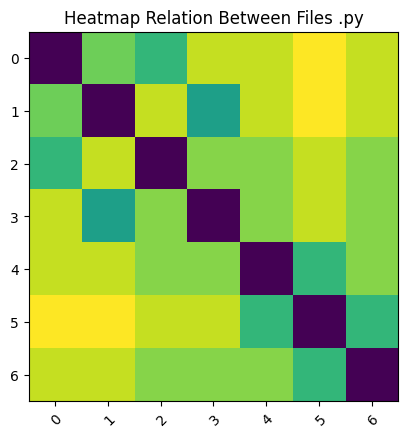

In [85]:
# Source: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

fig, ax = plt.subplots()
im = ax.imshow(distanceMatrix)

# Show all ticks and label them with the respective list entries
# ax.set_xticks(np.arange(len(list(listLabel))), labels=list(listLabel))
# ax.set_yticks(np.arange(len(list(listLabel))), labels=list(listLabel))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax.set_title("Heatmap Relation Between Files .py")

# plt.figure(figsize=(20,6))
plt.show()

#### Clustering

In [86]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import ward, median, centroid, weighted, average, complete, single, fcluster,linkage

In [87]:
tmpz = linkage(distanceMatrix)

/tmp/ipykernel_5636/3067466627.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tmpz = linkage(distanceMatrix)


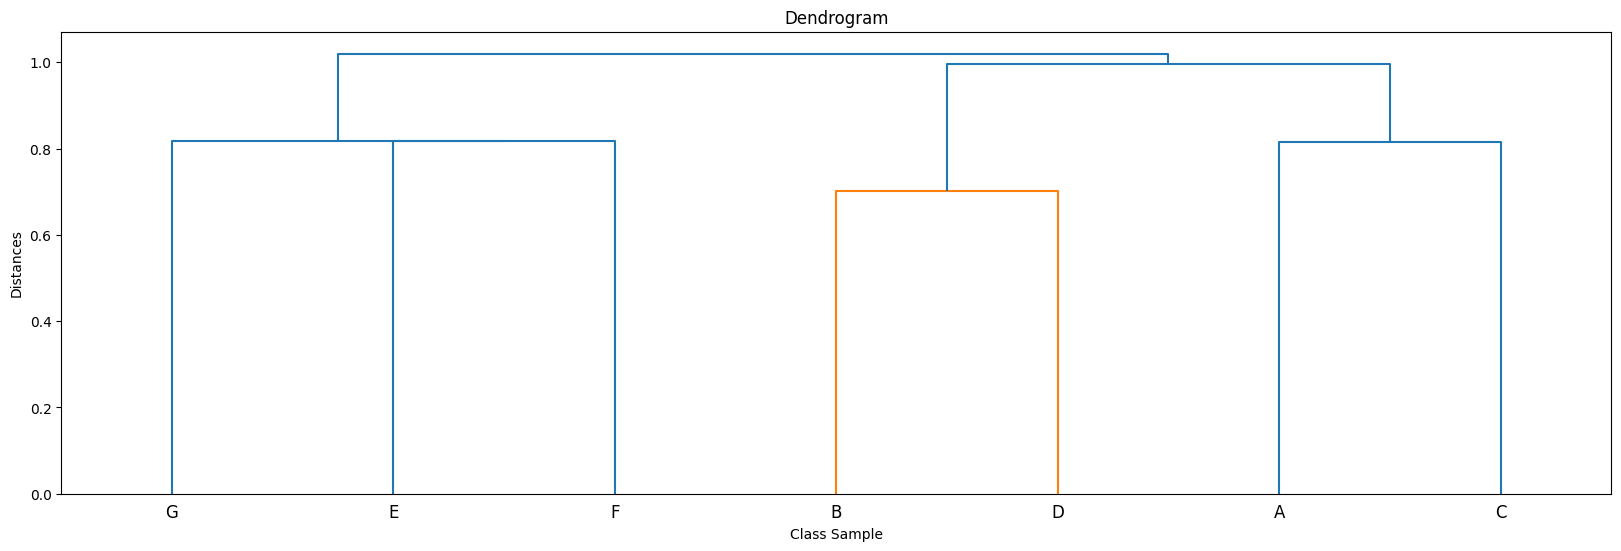

In [88]:
# import sys
# sys.setrecursionlimit(100000)
plt.figure(figsize=(20,6))
dend = sch.dendrogram(tmpz,labels=['A','B','C','D', 'E', 'F', 'G'])
plt.title('Dendrogram')
plt.xlabel('Class Sample')
plt.ylabel('Distances')
plt.show()

In [89]:

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(tmpz, pdist(distanceMatrix))
c

0.8667971423461205

##### Pemilihan Cluster 

Each row of the resulting array (Z) has the format [idx1, idx2, dist, sample_count].

In [91]:
for x in tmpz:
    print(x)

[1.         3.         0.70131622 2.        ]
[0.         2.         0.81524366 2.        ]
[4.         5.         0.81710192 2.        ]
[6.         9.         0.81710192 3.        ]
[7.        8.        0.9962764 4.       ]
[10.   11.    1.02  7.  ]


In [100]:
from scipy import cluster
cutree = cluster.hierarchy.cut_tree(tmpz, n_clusters=5)
cutree

array([[0],
       [1],
       [0],
       [1],
       [2],
       [3],
       [4]])

In [102]:
cutree = cluster.hierarchy.cut_tree(tmpz, n_clusters=6)
cutree

array([[0],
       [1],
       [2],
       [1],
       [3],
       [4],
       [5]])

In [106]:
def cutTreeToCluster(ct,label):
    c = {}
    idx = 0
    for x in ct:
        if x[0] not in c:
            c[x[0]] = []
        c[x[0]].append(label[idx])
        idx += 1
    return c        

In [111]:
for x in range(1,8):
    cutree = cluster.hierarchy.cut_tree(tmpz, n_clusters=x)
    print(cutTreeToCluster(cutree,['A','B','C','D', 'E', 'F', 'G']))

{0: ['A', 'B', 'C', 'D', 'E', 'F', 'G']}
{0: ['A', 'B', 'C', 'D'], 1: ['E', 'F', 'G']}
{0: ['A', 'C'], 1: ['B', 'D'], 2: ['E', 'F', 'G']}
{0: ['A', 'C'], 1: ['B', 'D'], 2: ['E', 'F'], 3: ['G']}
{0: ['A', 'C'], 1: ['B', 'D'], 2: ['E'], 3: ['F'], 4: ['G']}
{0: ['A'], 1: ['B', 'D'], 2: ['C'], 3: ['E'], 4: ['F'], 5: ['G']}
{0: ['A'], 1: ['B'], 2: ['C'], 3: ['D'], 4: ['E'], 5: ['F'], 6: ['G']}


In [92]:
# Based on Structural and Behavioral Dependencies:

In [115]:
def NbCalls(m,c1,c2):
    return m[c2][c1]

In [113]:
def CoupP(m, c1,c2):
    TotalNBCalls = 0
    for x in range(0,len(m)):
        if m[c1][x] > 0:
            TotalNBCalls += m[c1][x]
        if m[c2][x] > 0:
            TotalNBCalls += m[c2][x]
    return (NbCalls(m,c1,c2) + NbCalls(m,c2,c1))/TotalNBCalls

In [114]:
def InterCoup(M):
    sumCoup = 0
    NbPossiblePairs = len(m)
    for c1 in m:
        for c2 in m:
          sumCoup += CoupP(m,c1,c2)
    return sumCoup/NbPossiblePairs

In [120]:
def ExterCoup(m):
    #Jika root class ada di Odoo akan diklasifikasikan sebagai external
    #Mungkin ada penyimpanan hubungan external setiap class(library)
    return 0

In [119]:
def FAutonomy(m):
    return ExterCoup(m)

In [118]:
def InterCoh(m):
    NbDirectConnections = 0
    NbPossibleConnection = (len(m) * len(m)) - len(m)
    for row,  cls in enumerate(m):
        for cols, call in enumerate(cls):
            if row == cols:
                continue
            if call > 0:
                NbDirectConnections += call
    return NbDirectConnections / NbPossibleConnection

In [117]:
def FOne(m):
    return 1/2*(InterCoup(m)+InterCoh(m))

In [116]:
def FStructBeh(m):
    alpha = 1
    beta = 1
    return 1 / (alpha+beta) * (alpha * FOne(m) - beta * FAutonomy(m))

In [ ]:
# Simpan Measure dari :
# FStructBeh(m)